In [1]:
# ! pip3 install pydot
# ! pip3 install graphviz

#Atenttion To plot the graph you need also install graphviz in your system

In [2]:
import pandas as pd
import numpy as np
import copy
import math

from functools import reduce
from decimal import Decimal
import itertools

from graphviz import Digraph
import pydot


In [3]:
def graph_from_dict(dictionary,):
    edge_style = ""
    g = Digraph()
   
    for k in dictionary.keys():
        if any([k in sub for sub in dictionary.values() for key in dictionary.keys()]) or dictionary[k]:
            g.node(str(k),k, shape='oval', fontsize='10', width='0', style='filled', fillcolor='#c9c9c9', color="gray") 

    for k, i in dictionary.items():
        for it in i:
            g.edge(str(it), str(k), label='',style= edge_style, color='black')  
    return g

In [5]:
def alpha(df, i, parents): 
    parents = np.sort(parents)
    states = list(map(list, itertools.product([0, 1], repeat=len(parents)+1)))
    states_mod = [["".join(map(str,sublist[:len(sublist)-1]))]+[str(sublist[-1])] for sublist in states]
    gpd_values = pd.DataFrame()
  
    if len(parents):
        label_parents = ''.join(parents)
        df_to_group = pd.DataFrame(columns = [label_parents, df.columns[i]],
                                    data = np.transpose(
                                        [df.astype(str)[parents].apply(lambda x: "".join(x), axis=1).values,
                                        [str(item) for item in df[df.columns[i]]]]))

        
        gpd_values = df_to_group.groupby(by=
                                         [df_to_group[label_parents],
                                          df.columns[i]]).size()

        gpd_values = gpd_values.reset_index(name='size')

        for state in states_mod:
            if not state in gpd_values[[label_parents, df.columns[i]]].values.tolist() :
                gpd_values.loc[len(gpd_values)] = state+[0]
                gpd_values.sort_values(by=[label_parents, df.columns[i]], inplace=True)
        gpd_values.reset_index(inplace=True)
        gpd_values = gpd_values['size']
    
    else:
        gpd_values = df.groupby(df.columns[i]).size().values
    return gpd_values

In [6]:
def get_N(df, i, parents):
    parents = np.sort(parents)
    states = list(map(list, itertools.product([0, 1], repeat=len(parents))))
    gpd_values = None
    N = []
    if len(parents):
        cols_to_group = ([index for index in parents])
        cols_to_group.insert(0,df.columns[i])
        N = df[cols_to_group].groupby(cols_to_group[1:]).size()
        N = N.reset_index(name='size')
    
        for state in states:
            if not state in N[cols_to_group[1:]].values.tolist() :
                N.loc[len(N)] = state+[0]
                N.sort_values(by=cols_to_group[1:], inplace=True)
        N.reset_index(inplace = True)
        N = N['size']
    else:
        N = df.groupby(by=df.columns[i]).size().values.sum()
    return N

In [7]:
def f_mdl(df,x_i,pi, c):
    
    '''
        Minimum Length description metric score implementation
    '''
    N = len(df)
    r_i = len(df[df.columns[x_i]].unique())
    q_i = reduce(lambda x, y: x*y, [len(pd.unique(df[pai].values)) for pai in pi]) if pi  else 0
    Nij = get_N(df, x_i, pi)
    Nijk = alpha(df, x_i, pi)
    pbs = 0
  
    if(pi):
        for j in np.arange(0,q_i):
            for i in np.arange(0,r_i):
                if Nijk[2*j + i] and Nij[j]:
                      pbs += Nijk[2*j + i]*(math.log(Nijk[2*j + i]) - math.log(Nij[j]))          
                elif Nij[j]:
                    pbs += - math.log(Nij[j])
            pbs += -(c/2)*math.log(N)*q_i*(r_i -1)
    else:
        for i in np.arange(0,r_i):
            pbs += Nijk[i]*(math.log(Nijk[i]) - math.log(Nij))
        pbs += -(c/2)*math.log(N)*(r_i -1)
  
    return pbs

In [8]:
def f_ch(df, x_i, pi):
    '''
        Cooper-Herskovits metric score
        You can substitue factorial evaluations by log sum evaluations when working with large data
    '''
    prod = 1
#     prod = 0
    r_i = len(df[df.columns[x_i]].unique())
    alfa = alpha(df, x_i, pi)
    q_i = reduce(lambda x, y: x*y, [len(pd.unique(df[pai].values)) for pai in pi]) if pi  else 0
    Nij = get_N(df, x_i, pi)

    if pi:
        for j in np.arange(0,q_i):
            prod *= math.factorial(r_i - 1)/math.factorial(Nij[j] + r_i - 1)
#             prod += math.log(math.factorial(r_i - 1)) - math.log(math.factorial(Nij[j] + r_i - 1))
            for i in np.arange(0,r_i):
                prod *= math.factorial(alfa[2*j + i])
#             prod += math.log(math.factorial(alfa[2*j + i]))
    else:
        prod *= math.factorial(r_i - 1)/math.factorial(Nij + r_i - 1)
#         prod += math.log(math.factorial(r_i - 1)) - math.log(math.factorial(Nij + r_i - 1))
        for i in np.arange(0, r_i):
#             prod += math.log(math.factorial(alfa[i]))
            prod *= math.factorial(alfa[i])
    return prod

In [9]:
def k2(df_cases, tree_ogn,  c=1):
    
    '''K2 algorithm implementation
    
        df_cases: The dataframe of cases referrring the bayesian network, the columns are all the nodes 
        of the K2 pre-order         
        tree_ogn: A dictionary with the pre-order, 
            format required is {'node':[ 'parent_1', 'parent_2', ... 'parent_n'],
                                'node2': ['parent_1', 'parent_2', ... 'parent_n'],
                                'node_n: [['parent_1', 'parent_2', ... 'parent_n']]'}
        c: A factor for used in the evaluation of MDL score metric. Default = 1, (Optional)
    
        '''
    tree = copy.deepcopy(tree_ogn)
    dict_p = {}
  
    sigma = 0
    parents = [[] for node in df_cases.columns]
   
    count = 0
    for xi, col in enumerate(df_cases.columns):
        df = df_cases.copy()

        pold = f_ch(df_cases, xi, parents[xi])
        
#         using mdl as the metric score
#         pold = f_mdl(df_cases, xi, parents[xi], c)
    
        tree_xi = []
        if tree:
              tree_xi = tree[col]
    
        f_ances = []
        while (True):
            test_parents = [parents[xi]+[ances] for ances in tree_xi] if tree_xi else []
            f_ances = [f_ch(df, xi,parent) for parent in test_parents] if test_parents else [f_ch(df, xi, test_parents)]
            
            #using mdl as the score metric
            #f_ances = [f_mdl(df, xi,parent,c) for parent in test_parents] if test_parents else [f_mdl(df, xi, test_parents,c)]
            j_max = np.argmax(f_ances)

            sigma = f_ances[j_max]> pold
        
            if sigma:
                parents[xi] = parents[xi] + [no for no in [tree_xi[j_max]] if no not in parents[xi]]
                pold = f_ances[j_max]
  
            if tree_xi:
                del tree_xi[j_max]
      
            if(not sigma) or  (not tree_xi):
                break
        
    for i,parent in enumerate(parents):
        dict_p[df_cases.columns[i]] = parent
    return dict_p

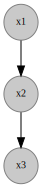

In [10]:
#Example with fake data 
#In this tree x1 has no parents, x2 has x1 as its parent and x3 hass x2 as its parents"

fake_tree = {'x1':[],
             'x2':['x1'],
             'x3':['x2']} 
    
graph_from_dict(fake_tree)

In [11]:
#dataframe with cases for the fake treee
fake_data = pd.DataFrame(columns=["x1", "x2", "x3"], data= np.transpose([[1,1,0,1,0,0,1,0,1,0], [0,1,0,1,0,1,1,0,1,0], [0,1,1,1,0,1,1,0,1,0]]))
display(fake_data)

,x1,x2,x3
0,1,0,0
1,1,1,1
2,0,0,1
3,1,1,1
4,0,0,0
5,0,1,1
6,1,1,1
7,0,0,0
8,1,1,1
9,0,0,0


In [12]:
#Example of running of K2 using Cooper-Herkovitz score metric

#In MDL score the default value to 'c' is 1. 
#If you want to use Cooper-Herskovits metric score metric do not pass the 'c' param
#In this implementation you have the possibility of changing the third parameter 'c' for MDL score

result = k2(fake_data,fake_tree)
print(result)

{'x1': [], 'x2': ['x1'], 'x3': ['x2']}


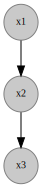

In [13]:
#Plot of the result obtained by K2
graph_from_dict(result)

The database of this example, the equation for computing f_ch metric 
as well as the basis algorithm for K2 implementation was based in the literature provided in:

    Gregory F. Cooper Edward Herskovits. A bayesian method for the induction of probabilistic networks from data. Technical Report KSL-91-02, Knowledge Systems Laboratory. Medical Computer Science. Stanford University School of
    Medicine, Stanford, CA 94305-5479, Updated Nov. 1993. Available at: http://smiweb.stanford.edu/pubs/SMI Abstracts/SMI-91-0355.html.
    
The mdl metric score was implemented based on the equation of the literature provided in:


    Bouckaert,  R.R.   Probabilistic network construction using the minimum description length principle.763European conference on symbolic and quantitative approaches to reasoning and uncertainty. Springer,7641993, pp. 41–48

